In [34]:
# Copyright Elasticsearch B.V. and/or licensed to Elasticsearch B.V. under one
# or more contributor license agreements. Licensed under the Elastic License;
# you may not use this file except in compliance with the Elastic License.

In [35]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import sklearn.datasets
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import seaborn as sns

from incremental_learning.job import train, update, evaluate
from incremental_learning.trees import Forest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Incremental Learning Illustration

This notebook illustrates how incremental learning improves the prediction of a trained model on previously unseen data.

But first, let's get an intuition behind our approach to incremental learning with decision forests, as shown in the illustration below. 

<img src="incremental-learning-update.gif">

* The initial training produces a model that consists of several prediction trees. Those are magenta, blue, and orange piecewise-linear functions predictions in our example. To evaluate the trained model, we evaluate all trees and aggregate the predictions to produce the final result.
* With new training points for the model update, we identify the best tree to catch the new information without losing the past information ("orange" in our example). 
* Then we re-train the selected tree using old and new data, increasing model fidelity or changing decision boundaries if needed.

Beware that we do not necessarily need to update the latest added tree in the model. We add trees in a specific sequence during the training, usually increasing the model fidelity as we progress. However, once the model is trained, the order of the trees is unimportant. As shown in the animation below, we obtain the same results by stacking predictions in a different order. 

<img src="incremental-learning-interchangable.gif"/>

Now, let's look at how well this works in practice. Although these two-dimensional examples are not simplified, they are well suited for illustration.


## Sine wave classification

In [36]:
dataset_name = 'classification-2d'

x = np.random.random(5000).reshape((-1,2))
y = x[:,1] < (np.sin(x[:,0]*np.pi/2*4)+1)/2
is_training = (x[:, 0] < 0.3) | (x[:,0] > 0.7) | (x[:,1] < 0.3) | (x[:,1] > 0.7)

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True:'true', False:'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()

Text(0.5, 1.0, 'Update dataset')

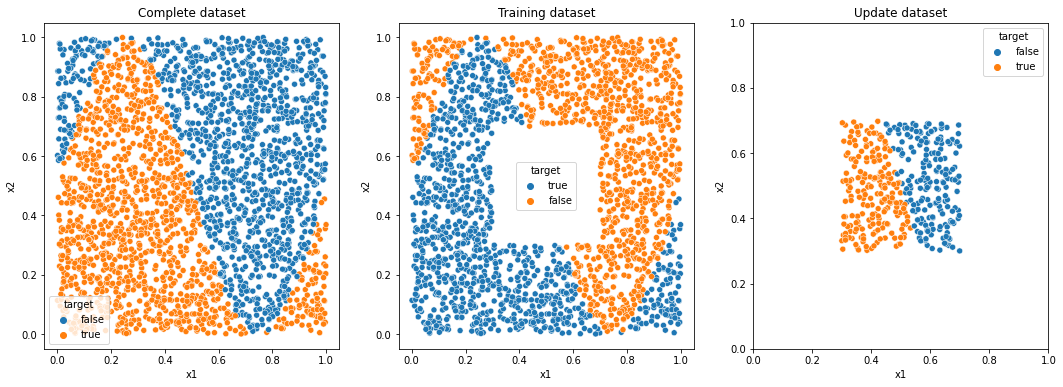

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0])
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1])
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2])
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [38]:
job1 = train(dataset_name, D_train[['x1','x2', 'target']], verbose=False)
job1.wait_to_complete()

True

In [39]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job1, verbose=False)
job2.wait_to_complete()

True

In [40]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1', 'x2', 'target']],
              original_job=job1, verbose=True)
job3.wait_to_complete()


stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpba68qudi --config /tmp/tmp2i5s1b09 --output /tmp/tmp_08affxn --restore /tmp/tmptx_c8pt7; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:54 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpba68qudi --config /tmp/tmp2i5s1b09 --output /tmp/tmp_08affxn --restore /tmp/tmptx_c8pt7; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
2021-07-22 11:54:51,037099 UTC [14197] DEBUG Main.cc@147 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-07-22 11:54:51,037150 UTC [14197] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-07-22 11:54:51,037161 UTC [14197] DEBUG CSystemCallFilter_Linux.cc@128 Seccomp BPF filters available
2021-07-22 11:54:51,037546 UTC [14197] DEBUG CSystemCallFilter_Linux.cc@154 Seccomp BPF installed
2021-07-22 11:54:51,048135 UTC [14197] DEBUG CDataFrameAnalyzer.cc@102 Received 612 rows
2021-07-22 11:54:51,052652 UTC [14197] DEBUG CBoostedTreeFactory.cc@1184 Quantiles 0.0829782 2.0417 53.5885
2021-07-22 11:54:51,786735 UTC [14197] INFO CBoostedTreeImpl.cc@391 Exiting hyperparameter optimisation loop early
2021-07-22 11:54:52,089906 UTC [14197] INFO Main.cc@255 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":12087095}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":371948}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":796}
]
2021-07-22 11:54:52,089949 UTC [14197] DEBUG Main.cc@260 ML data frame analyzer exiting
Success
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:54 $ 
 ,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"model_metadata":{"total_feature_importance":[],"hyperparameters":[{"name":"do
,{"compressed_data_summarization":{"doc_num":0,"data_summarization":"H4sIAAAAAAA
]

Job succeeded


True

In [41]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1', 'x2', 'target']],
                original_job=job3, verbose=False)
job4.wait_to_complete()


True

In [42]:
D['predictions'] = job2.get_predictions()
D['updated_predictions'] = job4.get_predictions()

In [43]:
def plot_sinus_values(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax)
    ax.add_patch(patches.Rectangle(xy=(0.3, 0.3), width=0.4, height=0.4, linewidth=2, color='red', fill=False))

def plot_misclassifications(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=(dataset[column]!=dataset['target']), 
                    ax=ax, palette=['grey', 'red'])
    ax.add_patch(patches.Rectangle(xy=(0.3, 0.3), width=0.4, height=0.4, linewidth=2, color='red', fill=False))

                     

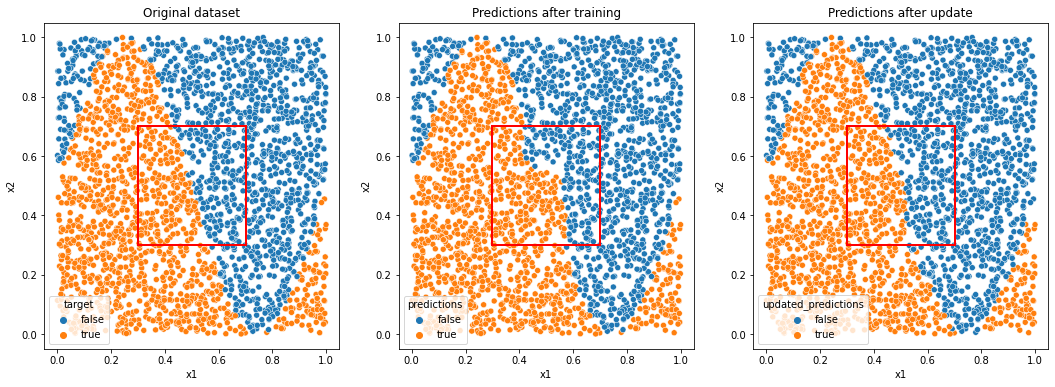

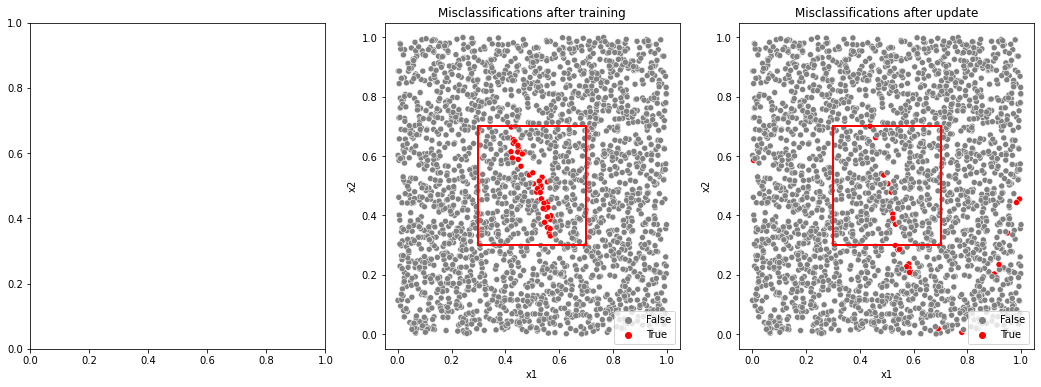

In [44]:
              
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_sinus_values(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_sinus_values(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_sinus_values(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_misclassifications(axes[1], 'predictions', D)
axes[1].set_title('Misclassifications after training')
plot_misclassifications(axes[2], 'updated_predictions', D)
axes[2].set_title('Misclassifications after update')
plt.show()

In [45]:
trained_models = job1.get_model_definition()['trained_model']['ensemble']['trained_models']
forest1= Forest(trained_models)

trained_models = job3.get_model_definition()['trained_model']['ensemble']['trained_models']
forest2= Forest(trained_models)

different = 0
for i in range(len(forest1.trees)):
    if not (forest1.trees[i] == forest2.trees[i]):
        print("Tree {}\nDifferent nodes for the old tree: {} out of {}\nDifferent nodes for the new tree: {} out of {}"
              .format(i, 
                      forest1.trees[i].num_diff_nodes(forest2.trees[i]),len(forest1.trees[i].nodes),
                      forest2.trees[i].num_diff_nodes(forest1.trees[i]),len(forest2.trees[i].nodes)
                     ))
        print(forest1.trees[i].nodes[0])
        print(forest2.trees[i].nodes[0])
        print("--------------------")
        different += 1
print("{:.2f}% different trees".format(100.0*different/len(forest1.trees)))
print("Topology change penalty {}".format(job3.get_hyperparameters()['tree_topology_change_penalty']))

Tree 1
Different nodes for the old tree: 29.0 out of 29
Different nodes for the new tree: 21.0 out of 21
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.6101367140395515, split_feature x1, split_gain 196.25775388312584
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.4045484866781486, split_feature x1, split_gain 154.31903869005595
--------------------
Tree 2
Different nodes for the old tree: 43.0 out of 43
Different nodes for the new tree: 23.0 out of 23
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.5563005278721991, split_feature x1, split_gain 172.3704910913327
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.3365224163969932, split_feature x1, split_gain 199.749302700639
--------------------
Tree 5
Different nodes for the old tree: 37.0 out of 37
Different nodes for the new tree: 27.0 out of 27
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.43834572236621744, split_feature x1, 

## Circles classification

In [46]:
dataset_name = 'classification-2d'

x = np.random.random(5000).reshape((-1,2))
y = ((x[:,1]-0.5)**2+(x[:,0]-0.5)**2 < 0.5**2) & ((x[:,1]-0.5)**2+(x[:,0]-0.5)**2 > 0.3**2)
is_training = (x[:,0]//0.25 + x[:,1]//0.25)%2 == 1

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True:'true', False:'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()

Text(0.5, 1.0, 'Update dataset')

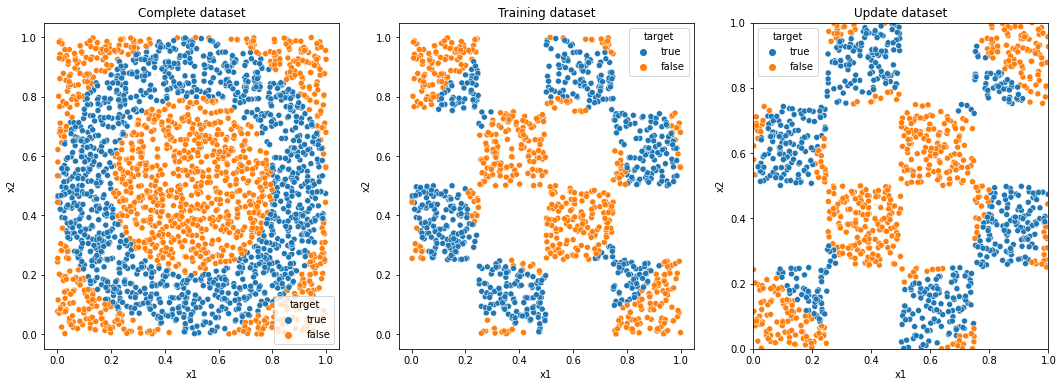

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0])
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1])
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2])
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [48]:
job1 = train(dataset_name, D_train[['x1','x2', 'target']], verbose=False)
job1.wait_to_complete()

True

In [49]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job1, verbose=False)
job2.wait_to_complete()

True

In [50]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1','x2', 'target']], original_job=job1, verbose=True)
job3.wait_to_complete()

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmp9h2xq4n6 --config /tmp/tmpfv8br0wi --output /tmp/tmpxn2i3oc4 --restore /tmp/tmpnkoy533t; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:55 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmp9h2xq4n6 --config /tmp/tmpfv8br0wi --output /tmp/tmpxn2i3oc4 --restore /tmp/tmpnkoy533t; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
2021-07-22 11:55:20,176893 UTC [20269] DEBUG Main.cc@147 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-07-22 11:55:20,176966 UTC [20269] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-07-22 11:55:20,176979 UTC [20269] DEBUG CSystemCallFilter_Linux.cc@128 Seccomp BPF filters available
2021-07-22 11:55:20,177372 UTC [20269] DEBUG CSystemCallFilter_Linux.cc@154 Seccomp BPF installed
2021-07-22 11:55:20,182892 UTC [20269] DEBUG CDataFrameAnalyzer.cc@102 Received 1390 rows
2021-07-22 11:55:20,184524 UTC [20269] DEBUG CBoostedTreeFactory.cc@1184 Quantiles 0.023334 1.48 29.2712
2021-07-22 11:55:20,304889 UTC [20269] INFO CBoostedTreeImpl.cc@391 Exiting hyperparameter optimisation loop early
2021-07-22 11:55:20,443419 UTC [20269] INFO Main.cc@255 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":8274376}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":266235}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":140}
]
2021-07-22 11:55:20,443472 UTC [20269] DEBUG Main.cc@260 ML data frame analyzer exiting
Success
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:55 $ 
 ,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"true","predi
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":"false","pred
,{"model_metadata":{"total_feature_importance":[],"hyperparameters":[{"name":"do
,{"compressed_data_summarization":{"doc_num":0,"data_summarization":"H4sIAAAAAAA
]

Job succeeded


True

In [51]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job3, verbose=False)
job4.wait_to_complete()

True

In [52]:
D['predictions'] = job2.get_predictions()
D['updated_predictions'] = job4.get_predictions()

In [53]:
def plot_checkerboard(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax)
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=-1))
                
def plot_misclassifications(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=(dataset[column]!=dataset['target']), 
                    ax=ax, palette=['grey', 'red'])
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=-1))

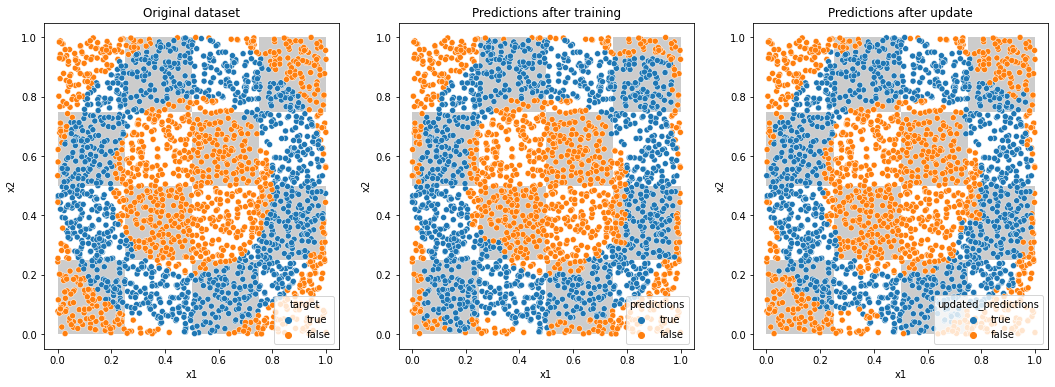

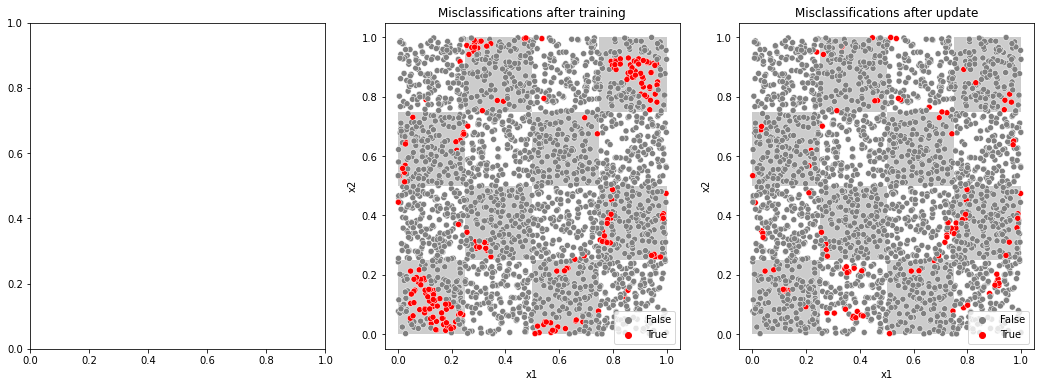

In [54]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_checkerboard(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_checkerboard(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_checkerboard(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_misclassifications(axes[1], 'predictions', D)
axes[1].set_title('Misclassifications after training')
plot_misclassifications(axes[2], 'updated_predictions', D)
axes[2].set_title('Misclassifications after update')
plt.show()

In [55]:
trained_models = job1.get_model_definition()['trained_model']['ensemble']['trained_models']
forest1= Forest(trained_models)

trained_models = job3.get_model_definition()['trained_model']['ensemble']['trained_models']
forest2= Forest(trained_models)

different = 0
for i in range(len(forest1.trees)):
    if not (forest1.trees[i] == forest2.trees[i]):
        print("Tree {}\nDifferent nodes for the old tree: {} out of {}\nDifferent nodes for the new tree: {} out of {}"
              .format(i, 
                      forest1.trees[i].num_diff_nodes(forest2.trees[i]),len(forest1.trees[i].nodes),
                      forest2.trees[i].num_diff_nodes(forest1.trees[i]),len(forest2.trees[i].nodes)
                     ))
        print(forest1.trees[i].nodes[0])
        print(forest2.trees[i].nodes[0])
        print("--------------------")
        different += 1
print("{:.2f}% different trees".format(100.0*different/len(forest1.trees)))
print("Topology change penalty {}".format(job3.get_hyperparameters()['tree_topology_change_penalty']))

Tree 1
Different nodes for the old tree: 59.0 out of 59
Different nodes for the new tree: 65.0 out of 65
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.9138779533029205, split_feature x2, split_gain 14.676558606812248
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.7886707825710895, split_feature x2, split_gain 45.12219058584297
--------------------
Tree 3
Different nodes for the old tree: 49.0 out of 49
Different nodes for the new tree: 37.0 out of 37
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.9421922072872182, split_feature x1, split_gain 5.22860026353872
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.4183682997170811, split_feature x1, split_gain 4.794099985317137
--------------------
10.00% different trees
Topology change penalty 0.1388677853012258


### Circles regression


In [56]:
dataset_name = 'regression-2d'

size = 5000
low = -np.pi
high = np.pi
x = np.random.uniform(low, high, 2*size).reshape(size, -1)
y = np.sin((x[:,0])**2+x[:,1]**2)
x = (x-low)/(high-low)

is_training = (x[:,0]//0.25 + x[:,1]//0.25)%2 == 1

D = pd.DataFrame(data=x, columns=['x1', 'x2'])
D['target'] = y
D['target'].replace({True:'true', False:'false'}, inplace=True)
D['training'] = is_training

D_train = D.where(D['training'] == True).dropna()
D_update = D.where(D['training'] == False).dropna()

Text(0.5, 1.0, 'Update dataset')

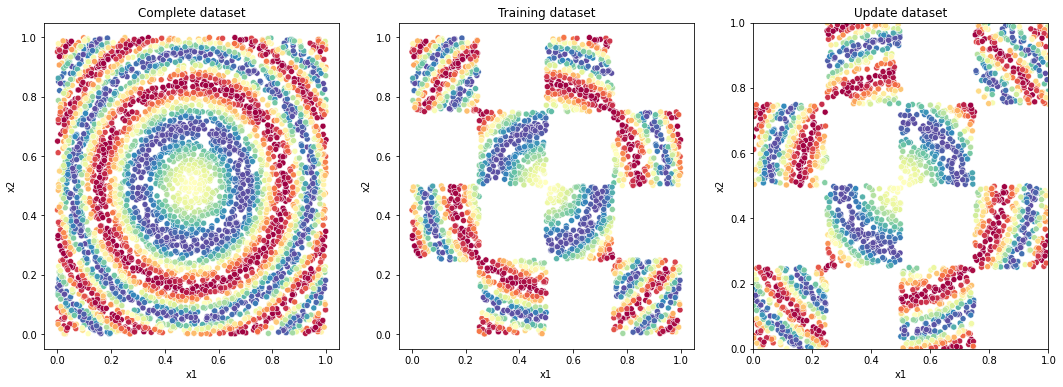

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(18,6))
# fig.suptitle('1 row x 2 columns axes with no data')
sns.scatterplot(data=D, x='x1', y='x2', hue='target', ax=axes[0], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[0].set_title('Complete dataset')
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[1], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[1].set_title('Training dataset')
sns.scatterplot(data=D_update, x='x1', y='x2', hue='target', ax=axes[2], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[2].set_xlim([0,1])
axes[2].set_ylim([0,1])
axes[2].set_title('Update dataset')

In [58]:
job1 = train(dataset_name, D_train[['x1','x2', 'target']], verbose=False)
job1.wait_to_complete()

True

In [59]:
job2 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job1, verbose=False)
job2.wait_to_complete()

True

In [60]:
D['predictions'] = job2.get_predictions()

In [61]:
job3 = update(dataset_name=dataset_name, dataset=D_update[['x1','x2', 'target']], original_job=job1, verbose=True)
job3.wait_to_complete()

stderr 
 output 
 
 
 /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpqdntjvw5 --config /tmp/tmphf1405z9 --output /tmp/tmpucnkobaz --restore /tmp/tmp51voxb9t; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:55 $ /home/valeriy/Documents/workspace/valeriy42/ml-cpp/build/distribution/platform/linux-x86_64/bin/data_frame_analyzer --input /tmp/tmpqdntjvw5 --config /tmp/tmphf1405z9 --output /tmp/tmpucnkobaz --restore /tmp/tmp51voxb9t; if [ $? -eq 0 ]; then echo "Success"; else echo "Failure"; fi
2021-07-22 11:55:54,057980 UTC [27100] DEBUG Main.cc@147 data_frame_analyzer (64 bit): Version based on 8.0.0-SNAPSHOT (Build DEVELOPMENT BUILD by valeriy) Copyright (c) 2021 Elasticsearch BV
2021-07-22 11:55:54,058030 UTC [27100] DEBUG CProcessPriority_Linux.cc@33 Successfully increased OOM killer adjustment via /proc/self/oom_score_adj
2021-07-22 11:55:54,058041 UTC [27100] DEBUG CSystemCallFilter_Linux.cc@128 Seccomp BPF filters available
2021-07-22 11:55:54,058424 UTC [27100] DEBUG CSystemCallFilter_Linux.cc@154 Seccomp BPF installed
2021-07-22 11:55:54,167386 UTC [27100] DEBUG CDataFrameAnalyzer.cc@102 Received 2717 rows
2021-07-22 11:55:54,200041 UTC [27100] DEBUG CBoostedTreeFactory.cc@1184 Quantiles 0.0125101 0.329501 6.409
2021-07-22 11:55:55,311354 UTC [27100] INFO Main.cc@255 [{"name":"E_DFTPMEstimatedPeakMemoryUsage","description":"The upfront estimate of the peak memory training the predictive model would use","value":23307700}
,{"name":"E_DFTPMPeakMemoryUsage","description":"The peak memory training the predictive model used","value":2419311}
,{"name":"E_DFTPMTimeToTrain","description":"The time it took to train the predictive model","value":588}
]
2021-07-22 11:55:55,311493 UTC [27100] DEBUG Main.cc@260 ML data frame analyzer exiting
Success
(env) ✔ ~/Documents/workspace/valeriy42/ml-cpp/jupyter/notebooks/prototypes [incremental-learning-datasets ↑·9|✚ 5⚑ 6]
13:55 $ 
 ,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":-0.4309886693
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":0.41866475343
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":0.89599347114
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":0.78182601928
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":0.76742285490
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":0.24144344031
,{"row_results":{"checksum":0,"results":{"ml":{"target_prediction":-0.7262526750
,{"model_metadata":{"total_feature_importance":[],"hyperparameters":[{"name":"tr
,{"compressed_data_summarization":{"doc_num":0,"data_summarization":"H4sIAAAAAAA
]

Job succeeded


True

In [62]:
job4 = evaluate(dataset_name=dataset_name, dataset=D[['x1','x2', 'target']], original_job=job3, verbose=False)
job4.wait_to_complete()

True

In [63]:
def plot_checkerboard(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=column, ax=ax, palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=5))
                
def plot_error(ax, column, dataset):
    sns.scatterplot(data=dataset, x='x1', y='x2', hue=np.abs(dataset[column]-dataset['target']), 
                    ax=ax, palette="YlOrBr", hue_norm=(0, 2.0), legend=False)
    for i in range(4):
        for j in range(4):
            if (i+j)%2 ==0:
                ax.add_patch(patches.Rectangle(xy=(0.25*i, 0.25*j), width=0.25, height=0.25, 
                                   linewidth=0, color='grey', fill=True, alpha=0.4, zorder=5))

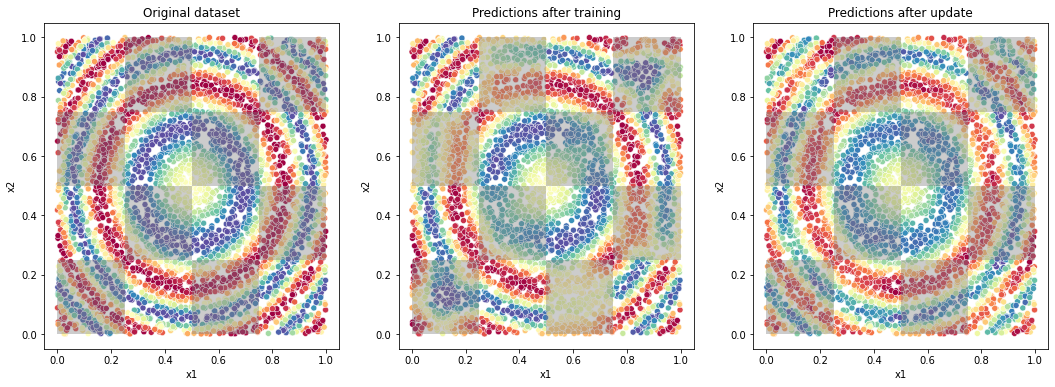

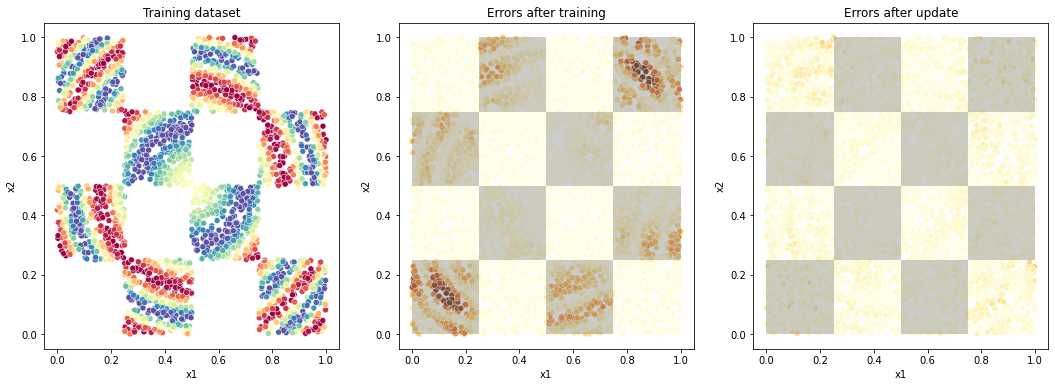

In [64]:
D['updated_predictions'] = job4.get_predictions()

fig, axes = plt.subplots(1, 3, figsize=(18,6))
plot_checkerboard(axes[0], 'target', D)
axes[0].set_title('Original dataset')
plot_checkerboard(axes[1], 'predictions', D)
axes[1].set_title('Predictions after training')
plot_checkerboard(axes[2], 'updated_predictions', D)
axes[2].set_title('Predictions after update')

fig, axes = plt.subplots(1, 3, figsize=(18,6))
sns.scatterplot(data=D_train, x='x1', y='x2', hue='target', ax=axes[0], palette='Spectral', 
                    hue_norm=(-1.0, 1.0), legend=False)
axes[0].set_title('Training dataset')
plot_error(axes[1], 'predictions', D)
axes[1].set_title('Errors after training')
plot_error(axes[2], 'updated_predictions', D)
axes[2].set_title('Errors after update')
plt.show()

In [65]:
trained_models = job1.get_model_definition()['trained_model']['ensemble']['trained_models']
forest1= Forest(trained_models)

trained_models = job3.get_model_definition()['trained_model']['ensemble']['trained_models']
forest2= Forest(trained_models)

different = 0
for i in range(len(forest1.trees)):
    if not (forest1.trees[i] == forest2.trees[i]):
        print("Tree {}\nDifferent nodes for the old tree: {} out of {}\nDifferent nodes for the new tree: {} out of {}"
              .format(i, 
                      forest1.trees[i].num_diff_nodes(forest2.trees[i]),len(forest1.trees[i].nodes),
                      forest2.trees[i].num_diff_nodes(forest1.trees[i]),len(forest2.trees[i].nodes)
                     ))
        print(forest1.trees[i].nodes[0])
        print(forest2.trees[i].nodes[0])
        print("--------------------")
        different += 1
print("{:.2f}% different trees".format(100.0*different/len(forest1.trees)))
print("Topology change penalty {}".format(job3.get_hyperparameters()['tree_topology_change_penalty']))

Tree 4
Different nodes for the old tree: 283.0 out of 283
Different nodes for the new tree: 177.0 out of 177
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.6907648019289473, split_feature x1, split_gain 7.43226985774061
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.7705895142967777, split_feature x2, split_gain 0.10459586505832673
--------------------
Tree 5
Different nodes for the old tree: 265.0 out of 265
Different nodes for the new tree: 231.0 out of 231
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.7464200665787285, split_feature x2, split_gain 9.791165873538526
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.7533803340912504, split_feature x1, split_gain 0.9522421722801906
--------------------
Tree 9
Different nodes for the old tree: 281.0 out of 281
Different nodes for the new tree: 187.0 out of 187
Node 0: is_leaf False, left_child_id 1, right_child_id 2
threshold 0.7464200665787285, split_

In [66]:
job3.get_hyperparameters()


{'tree_topology_change_penalty': 0.05910430459484778,
 'downsample_factor': 0.32373093479754067,
 'alpha': 0.030874541018258633,
 'lambda': 3.294462705265273,
 'gamma': 0.005615769315850298,
 'soft_tree_depth_limit': 8.679642880315347,
 'soft_tree_depth_tolerance': 0.125,
 'eta': 0.03953643111282544,
 'eta_growth_rate_per_tree': 1.0206345138152169,
 'max_trees': 274,
 'feature_bag_fraction': 0.5375000000000001,
 'prediction_change_cost': 1.031338537721246,
 'retrained_tree_eta': 0.20720376022781234}